Sat May  3 14:04:57 2025
Matplotlib:  3.1.1
Numpy     :  1.17.2
Pandas   :  0.25.1
Xarray   :  0.14.0
Both groups of files are on the same vertical grid after interpolation.
NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_plio.nc
NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_pi.nc
<xarray.Dataset>
Dimensions:  (lev: 43, lon: 360)
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 1106.2042 1244.5669 1400.4972
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    TEMP     (lev, lon) float64 2.105 2.102 2.096 2.1 ... 2.369 2.37 2.367 2.37
Min and Max Depth Values for Each Species Array:
<xarray.DataArray (stat: 2, index: 8)>
array([[  5.  ,   5.  ,   0.  ,   0.  ,  21.35,  82.7 ,  82.7 ,  82.7 ],
       [ 25.  ,  25.  , 232.27, 232.27, 592.43, 747.84, 747.84, 747.84]])
Coordinates:
  * stat     (stat) <U9 'min_depth' 'max_dep

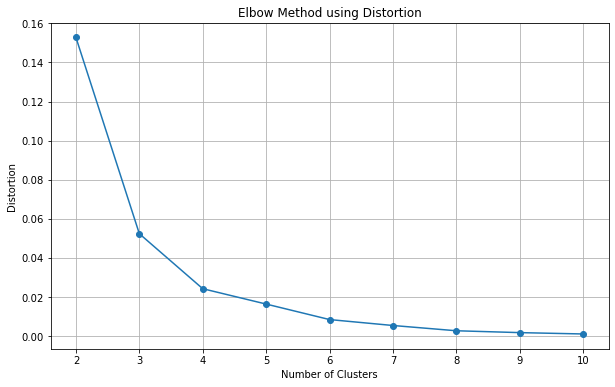

In [2]:
# Importing necessary libraries
import datetime  # For working with dates and times
import os  # For interacting with the operating system
import warnings  # For suppressing warnings

import xesmf as xe
import cartopy.crs as ccrs  # For geographic plotting
import matplotlib as mpl  # Main plotting library
import matplotlib.colors as mcolors  # For working with colors in plots
import matplotlib.pyplot as plt  # For creating plots
from matplotlib.colors import Normalize  # For normalizing colors in plots
import numpy as np  # For numerical computing
import pandas as pd  # For data manipulation and analysis
import scipy.stats as stats  # For statistical analysis
from scipy import stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import xarray as xr  # For working with labeled multidimensional arrays
from cartopy.util import add_cyclic_point  # For adding cyclic points to data
from sklearn.cluster import KMeans  # For performing K-means clustering
from sklearn.metrics import mean_squared_error  # For calculating mean squared error
from scipy.stats import norm  # For normal distribution functions
from matplotlib.colors import ListedColormap  # For defining a colormap from a list of colors
from matplotlib.colors import LinearSegmentedColormap  # For defining a colormap from a sequence of colors
from matplotlib.colorbar import ColorbarBase  # For creating a colorbar
from sklearn.metrics import silhouette_samples, silhouette_score  # For silhouette analysis

# Configuration options
suppress_warnings = True  # Option to suppress warnings
suppress_plots = False  # Option to suppress plots

# Suppressing warnings if suppress_warnings is True
if suppress_warnings:
    warnings.filterwarnings("ignore")

# Suppressing plots if suppress_plots is True
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

# Printing current date and library versions
print(datetime.datetime.ctime(datetime.datetime.today()))  # Print current date and time
print("Matplotlib: ", mpl.__version__)  # Print Matplotlib version
print("Numpy     : ", np.__version__)  # Print NumPy version
print("Pandas   : ", pd.__version__)  # Print Pandas version
print("Xarray   : ", xr.__version__)  # Print Xarray version

# Setting a path to the Excel file
path = '/glade/u/home/nwrye/OceanTemps_Compiles/PlioMIP2data.xlsx'

# Load data from Excel into a pandas DataFrame
df = pd.read_excel(path)

# Selecting specific columns from the DataFrame (longitude, depth, -95%CL, median, 95%CL)
data = df.iloc[:, [1, 2, 3, 4, 5, 6]]

# Convert DataFrame to a numpy array to allow direct indexing and modification
data_array = data.to_numpy()

# Find the indices of the negative values in the first column
negative_indices = data_array[:, 0] < 0

# Add 360 to the negative values using the indices
data_array[negative_indices, 0] += 360

# Convert the modified numpy array back to a DataFrame (if needed)
data_modified = pd.DataFrame(data_array, columns=data.columns)

# Renaming columns
data_modified.columns = ['longitude', 'depth', 'species', 'neg95', 'median', 'pos95']

# Changing the depth value in the first row to 10
data_modified.at[0:1, 'depth'] = 15

# Multiplying all values in the depth column by -1
data_modified['depth'] *= -1

# Replace NaN values in the 'longitude' column with 0 (or any default value)
data_modified['longitude'].fillna(0, inplace=True)

# Round the 'longitude' values to the nearest whole number
data_modified['longitude'] = data_modified['longitude'].round()

# Convert the DataFrame to an xarray Dataset
dsa = data_modified.to_xarray()

# Convert specific columns to desired data types
dsa['depth'] = dsa['depth'].astype('float')
dsa['neg95'] = dsa['neg95'].astype('float')
dsa['median'] = dsa['median'].astype('float')
dsa['pos95'] = dsa['pos95'].astype('float')
dsa['species'] = dsa['species'].astype('str')

# Define the directory path for slice files
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/'

# List of file names to process for plio files and pi files respectively
pliofile_names = ['CCSM4_plio.nc', 'CESM1.2_plio.nc', 'CESM2_plio.nc', 'COSMOS_plio.nc',
                'EC_Earth3.3_plio.nc', 'HADGEM3_NEW_1997_plio.nc','MIROC4_2004_plio.nc', 'Utrecht_CESM1.0.5_plio.nc','IPSLCM6A_LR_plio.nc', 'GISS_plio.nc',
                'LEEDS_plio.nc', 'NorESM-F_plio.nc','IPSLCM5A_plio.nc', 'IPSLCM5A2_plio.nc']

pifile_names = ['CCSM4_pi.nc', 'CESM1.2_pi.nc',
                'CESM2_pi.nc', 'COSMOS_pi.nc', 'EC_Earth3.3_pi.nc', 'HADGEM3_NEW_1997_pi.nc',
                'MIROC4_2004_pi.nc', 'Utrecht_CESM1.0.5_pi.nc','IPSLCM6A_LR_pi.nc', 'GISS_pi.nc','LEEDS_pi.nc', 'NorESM-F_pi.nc', 'IPSLCM5A_pi.nc', 'IPSLCM5A2_pi.nc' ]

# Create an empty list to store sliced datasets for plio and pi files
pisds = []
pliosds = []

# Open and interpolate plio files
# Iterate through each plio file
for fname in pliofile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            
            pliosds.append(sliced)
            # Interpolate the data to the same level values as the first dataset if more than one dataset is present
            if len(pliosds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pliosds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Open and interpolate pi files
# Iterate through each pi file
for fname in pifile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            pisds.append(sliced)
            # Interpolate the data to the same level values as the plio dataset if more than one dataset is present
            if len(pisds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pisds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Check if both groups of files are on the same lev grid after interpolation
if len(pliosds) > 0 and len(pisds) > 0:
    plio_lev_values = pliosds[0].lev.values
    pi_lev_values = pisds[0].lev.values

    # Check if the level values of plio and pi datasets are the same
    if (plio_lev_values == pi_lev_values).all():
        print("Both groups of files are on the same vertical grid after interpolation.")
    else:
        print("Both groups of files are not on the same vertical grid after interpolation.")
else:
    print("No data found to compare.")

# Define the function to calculate horizontal temperature difference
def horizontal_difference(plio_ds, pi_ds): 
    
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    dif = plio_ds['TEMP'] - pi_ds['TEMP'] 
    diff = dif.mean('lat', skipna=True)
    return diff

# Take the mean across all datasets in the pliosds list
concatenated = xr.concat(pliosds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multiplio = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_plio.nc"  # Specify the output file path
multiplio.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}")  # Print a confirmation message with the output file path

# Take the mean across all datasets in the pisds list
concatenated = xr.concat(pisds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multipi = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_pi.nc"  # Specify the output file path
#multipi.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}") 

excel_path = os.path.join(
    "/glade/u/home/nwrye/OceanTemps_Compiles", "Lakhani_depths.xlsx"
)

# Load data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_path)

# Filter the DataFrame to include only 'sacculifer', 'dutertrei', and 'tumida' species
selected_species = ["sacculifer", "dutertrei", "tumida"]
df_filtered = df[df["species"].isin(selected_species)]

opath = "/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/"
anom_names = [
    "CCSM4_anomaly.nc", "CESM1.2_anomaly.nc", "CESM2_anomaly.nc",
    "COSMOS_anomaly.nc", "EC_Earth3.3_anomaly.nc", "HADGEM3_NEW_1997_anomaly.nc",
    "MIROC4_2004_anomaly.nc", "Utrecht_CESM1.0.5_anomaly.nc", "IPSLCM6A_LR_anomaly.nc",
    "GISS_anomaly.nc", "LEEDS_anomaly.nc", "NorESM-F_anomaly.nc",
    "IPSLCM5A_anomaly.nc", "IPSLCM5A2_anomaly.nc"]

anom_files = []

for i in range(len(anom_names)):
    ds = xr.open_dataset(opath + anom_names[i])
    anom_files.append(ds)

# List of model names for future use
model_names = ["CCSM4", "CESM1.2", "CESM2", "COSMOS", "EC_Earth3.3", "HADGEM3", "MIROC4", "Utrecht", "IPSLCM6A",
               "GISS", "LEEDS", "NorESM-F", "IPSLCM5A", "IPSLCM5A2"]

# Calculate the horizontal difference using the 'horizontal_difference' function
mmm = horizontal_difference(multiplio, multipi)

# Convert the resulting DataArray 'mmm' to a Dataset named 'multi_model_mean'
multi_model_mean = mmm.to_dataset(name="TEMP")

# Print the dataset
print(multi_model_mean)

# Append the multi-model mean dataset to the 'anom_files' list
anom_files.append(multi_model_mean)

# Extract relevant columns for the xarray dataset
selected_columns = ["longitude", "species", "calc_depth"]
lon_sites = dsa["longitude"]

# Exclude first two sites (alkenones) as there is no depth presence distribution for them
xpositions = np.array(lon_sites)

species_sites = dsa["species"]

# Create a list of arrays where each array contains 'calc_depth' values for a specific species
violin_data = [
    df_filtered[df_filtered["species"] == species_sites[i]]["calc_depth"].values
    for i in range(len(xpositions))
]

# The depth is the surrounding vertical grid cells which, after interpolation, start at 5m and 25m
prescribed_alk_depth = [5, 25]

# Changing the alkenones data
violin_data[0] = prescribed_alk_depth
violin_data[1] = prescribed_alk_depth

# Make sure that the first two index for alkenones species have prescribed calc_depths of 5 and 25m

# Initialize empty arrays for minimum and maximum values
min_values = np.empty(len(violin_data))
max_values = np.empty(len(violin_data))

# Loop through each indexed array in violin_data
for i, data_array in enumerate(violin_data):
    # Find minimum and maximum values for the current array
    min_values[i] = np.round(np.min(data_array), 2)
    max_values[i] = np.round(np.max(data_array), 2)

# Create xarray DataArray for both min and max values
min_max_values_da = xr.DataArray(
    data=np.vstack((min_values, max_values)),
    dims=("stat", "index"),
    coords={"stat": ["min_depth", "max_depth"], "index": range(len(min_values))},
)

# Print out max and min depth values for each species 
print("Min and Max Depth Values for Each Species Array:")
print(min_max_values_da)

# Create xarray Dataset
combined_dataset = xr.Dataset(
    data_vars={"min_depth": ("species", min_max_values_da.sel(stat="min_depth")),
                "max_depth": ("species", min_max_values_da.sel(stat="max_depth")),
                "longitude": ("species", xpositions)},
    coords={"species": ["alkenones", "alkenones", "sacculifer", "sacculifer", "dutertrei", "tumida", "tumida", "tumida"]}
)

# Remove the time coordinate if it exists
if "time" in combined_dataset.coords:
    combined_dataset = combined_dataset.drop_vars("time")

# Print or use the modified dataset as needed
print(combined_dataset)

model_names = ["CCSM4", "CESM1.2", "CESM2", "COSMOS", "EC_Earth3.3", "HADGEM3",
               "MIROC4", "Utrecht", "IPSLCM6A", "GISS", "LEEDS", "NorESM-F", "IPSLCM5A", "IPSLCM5A2", "MMM"]

# Create an empty xarray Dataset
model_dataset = xr.Dataset()

for i, model_name in enumerate(model_names):
    data = anom_files[i]["TEMP"]

    model_dataset[model_name] = data  # Add the data variable to the Dataset

# Remove the time coordinate if it exists in the second dataset
if "time" in model_dataset.coords:
    model_dataset = model_dataset.drop("time")

# Print or use the resulting model_dataset
print(model_dataset)

def Bias(o_min, m_max, o_max, m_min):
    """
    Calculate the bias between observational and model data.

    Parameters:
        - o_min: Minimum value from observational data.
        - m_max: Maximum value from model data.
        - o_max: Maximum value from observational data.
        - m_min: Minimum value from model data.

    Returns:
        - prbias: Bias between observational and model data.
    """
    # Calculate the differences
    diff1 = o_min - m_max
    diff2 = m_min - o_max
    
    # Check conditions and calculate prbias
    if diff1 > 0:
        prbias = -diff1
    elif diff2 > 0:
        prbias = diff2
    elif np.isnan(diff1) or np.isnan(diff2):
        prbias = np.nan
    else:
        prbias = 0
        
    return prbias

num_species = len(combined_dataset["species"])
num_models = len(model_names)

min_temps = np.zeros((num_species, num_models))
max_temps = np.zeros((num_species, num_models))

# Looping through each species
for i, species in enumerate(combined_dataset["species"]):
    # Looping each Longitude with every species change
    species_lon = combined_dataset["longitude"].isel(species=i).item()

    # Find the min and max depth for the species at the specified longitude
    min_depth = combined_dataset["min_depth"].isel(species=i).item()
    max_depth = combined_dataset["max_depth"].isel(species=i).item()

    # print(f"\nSpecies: {species}, Longitude: {species_lon}, Min Depth: {min_depth}, Max Depth: {max_depth}")

    # Looping through all models for the current species
    for j, model in enumerate(model_names):
        # print(f"\nModel: {model}")

        # Filter model_dataset within the specified depth range and longitude for the current model and species
        filtered_dataset = model_dataset[model].sel(
            lev=slice(min_depth, max_depth), lon=species_lon
        )

        # print("Filtered Dataset:")
        # print(filtered_dataset)

        # Find the min and max values for the current model and species along the 'lev' dimension only
        max_values = filtered_dataset.max(dim="lev").values
        min_values = filtered_dataset.min(dim="lev").values

        # print(f"Min values: {min_values}, Max values: {max_values}")

        # Save max and min values in the arrays
        max_temps[i, j] = max_values
        min_temps[i, j] = min_values

# Create an xarray dataset with the resulting arrays
result_dataset = xr.Dataset(
    {"min_temps": (["species", "models"], min_temps),
     "max_temps": (["species", "models"], max_temps),
     "species_lon": (["species"], combined_dataset["longitude"])},
    coords={"species": combined_dataset["species"], "models": model_names}
)
# Display the resulting xarray dataset
#print("\nResult Dataset:")
#print(result_dataset)

lower_bound = dsa["neg95"]
upper_bound = dsa["pos95"]
#print(lower_bound)
#print(upper_bound)

# Create an empty array for bias values
bias_values = np.zeros((num_species, num_models))

# Loop through each species and model
for i, species in enumerate(result_dataset["species"]):
    for j, model in enumerate(result_dataset["models"]):
        # Get the min and max values from the result_dataset
        o_min = lower_bound[i].item()
        m_max = result_dataset["max_temps"].isel(species=i, models=j).item()
        o_max = upper_bound[i].item()
        m_min = result_dataset["min_temps"].isel(species=i, models=j).item()

        # Calculate the bias using the Bias function
        bias_value = Bias(o_min, m_max, o_max, m_min)

        # Save bias value in the array
        bias_values[i, j] = bias_value

# Add the bias values as a new data variable in the result_dataset
result_dataset["Bias"] = (["species", "models"], bias_values)

# Calculate RMSB for each model
rmsb_values = np.sqrt(np.nanmean(bias_values**2, axis=0))

# Add RMSE values as a new data variable in the result_dataset
result_dataset["RMSB"] = (["models"], rmsb_values)

# Display the updated result_dataset
print("\nUpdated Result Dataset with Bias and RMSB:")
print(result_dataset)

# Define a list of columns you want to keep
desired_columns = ['Bias', 'species_lon']

rmsb = result_dataset["RMSB"][:-2]

# Iterate over each model
for model in result_dataset.models:
    # Access data for the current model
    model_data = result_dataset.sel(models=model)
    
    # Convert the subset to a Pandas DataFrame and reset the index
    model_dataframe = model_data.to_dataframe().reset_index()
    
    # Select only the desired columns
    model_dataframe_subset = model_dataframe[desired_columns]
    
    # Drop duplicates if any
    model_dataframe_subset = model_dataframe_subset.drop_duplicates()

# Initialize a list to store distortion values
distortions = []

# Create a range of number of clusters to iterate over
cluster_range = range(2, 11)

# Iterate over each number of clusters
for num_clusters in cluster_range:
    # Assuming you have a numeric dataset for clustering (rmsb in this case)
    numeric_data = np.array(rmsb).reshape(-1, 1)

    # Create a KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the KMeans model to the data
    kmeans.fit(numeric_data)

    # Calculate distortion (WCSS) and append to the list
    distortions.append(kmeans.inertia_)

# Plotting the distortion values
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, distortions, marker='o', linestyle='-')
plt.title('Elbow Method using Distortion')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.xticks(cluster_range)
plt.grid(True)

# Setting output path
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

# Save the silhouette plot as an image file
#plt.savefig(path + "Distortion_Elbow_Method.pdf")
plt.show()